# Combining all collected magnetics data

Once you finished the data processing from all individual smartphones, they can all be put together for a combined analysis. Note that, if you used the base-station correction, any error between smartphones is already accounted for.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy import interpolate
import pandas as pd
from pathlib import Path

## Loading all datasets

First we make use of the [os-module](https://docs.python.org/3/library/os.html) in order to access the files on the computer. The variable 'dr' can be changed to specify a data directory different from the one this notebook is contained in.

In [3]:
dr = 'results/'
preamble = 'results_magnetic_' # The filename beginning common to all magnetic data files
preambleBASE = 'results_magneticBASE_' # Filename beginning for all base station data

alldata = [] # Empty list for storing all dataframes
basedata = [] # Empty list for storing all base station dataframes

for file in os.scandir(dr):
    if file.is_file and file.name.endswith('.csv') and file.name.startswith(preamble): # Check if this is a data file
        alldata.append(pd.read_csv(file))
    elif file.is_file and file.name.endswith('.csv') and file.name.startswith(preambleBASE): # Check if this is a data file
        basedata.append(pd.read_csv(file))
        
data_combined = pd.concat(alldata, ignore_index=True)
base_combined = pd.concat(basedata, ignore_index=True)

In [4]:
# Taking a look at the combined data
data_combined.describe()


Unnamed: 0     Station             y              x   height(m)  \
count  153.000000  153.000000  1.530000e+02     153.000000  153.000000   
mean    42.379085   42.627781  5.636209e+06  307645.831286  133.116794   
std     25.156878   25.289462  7.047222e+01      72.290076   23.172715   
min      0.000000    0.000000  5.636047e+06  307502.032501  103.987114   
25%     22.000000   22.111111  5.636156e+06  307589.750521  112.484325   
50%     41.000000   41.207071  5.636220e+06  307663.862479  115.085271   
75%     61.000000   61.442029  5.636258e+06  307706.658304  158.514409   
max     96.000000   96.484848  5.636333e+06  307755.046493  159.944997   

              field         t(s)         times       z_dem     field_alt  \
count    153.000000   153.000000    153.000000  153.000000    153.000000   
mean   47587.046326  2811.174075  43690.801069  159.115686  47226.420477   
std     3087.342651  1748.205755   1705.901917    1.123000   3735.276594   
min    38431.255410    28.932302  40459.342302  156.540000  37176.172896   
25%    46452.935110  1464.654070  42334.382886  158.630000  44888.475687   
50%    47306.727420  2380.212523  43401.192198  159.430000  48461.296870   
75%    48748.209410  3912.532586  44815.742678  159.830000  49811.375260   
max    56119.106620  6552.400902  46982.810902  161.350000  55668.187547   

            anomaly  
count    153.000000  
mean      24.792871  
std     3159.584203  
min   -10544.046304  
25%     -811.317333  
50%        0.000000  
75%     1563.068326  
max     9572.536963

In [5]:
base_combined.describe()


Unnamed: 0    Station             y              x   height(m)  \
count     8.00000   8.000000  8.000000e+00       8.000000    8.000000   
mean     55.00000  55.314010  5.636329e+06  307675.784956  126.584723   
std      36.46133  36.658184  6.720421e+00       5.891578   24.544634   
min       0.00000   0.000000  5.636315e+06  307671.233552  104.587847   
25%      40.50000  40.704545  5.636329e+06  307672.158121  109.707105   
50%      66.00000  66.478261  5.636332e+06  307672.888981  110.330408   
75%      74.50000  74.876263  5.636332e+06  307677.150639  153.131758   
max      96.00000  96.484848  5.636333e+06  307687.004112  158.896202   

              field         t(s)         times       z_dem     field_alt  \
count      8.000000     8.000000      8.000000    8.000000      5.000000   
mean   48709.286103  3805.895901  44604.503401  156.640000  49452.900488   
std     3554.417218  2570.246944   2568.695464    0.134589   4364.488410   
min    44475.028950    28.932302  40459.342302  156.540000  44483.552336   
25%    45953.002877  2219.944753  42895.819753  156.567500  46006.907843   
50%    48313.211200  4660.365698  45581.705699  156.575000  49942.813243   
75%    50282.950873  5632.593660  46598.070048  156.647500  51418.174820   
max    55434.293390  6552.400902  46982.810902  156.910000  55413.054197   

       anomaly  
count      5.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

## Plotting all data

We can now visualize all collected data. Starting with a scatterplot:

<ipython-input-6-e2f839a301f1>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
<ipython-input-6-e2f839a301f1>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:}'.format(int(x)) for x in ax2.get_yticks().tolist()]) # Fixes y-axis tick labels


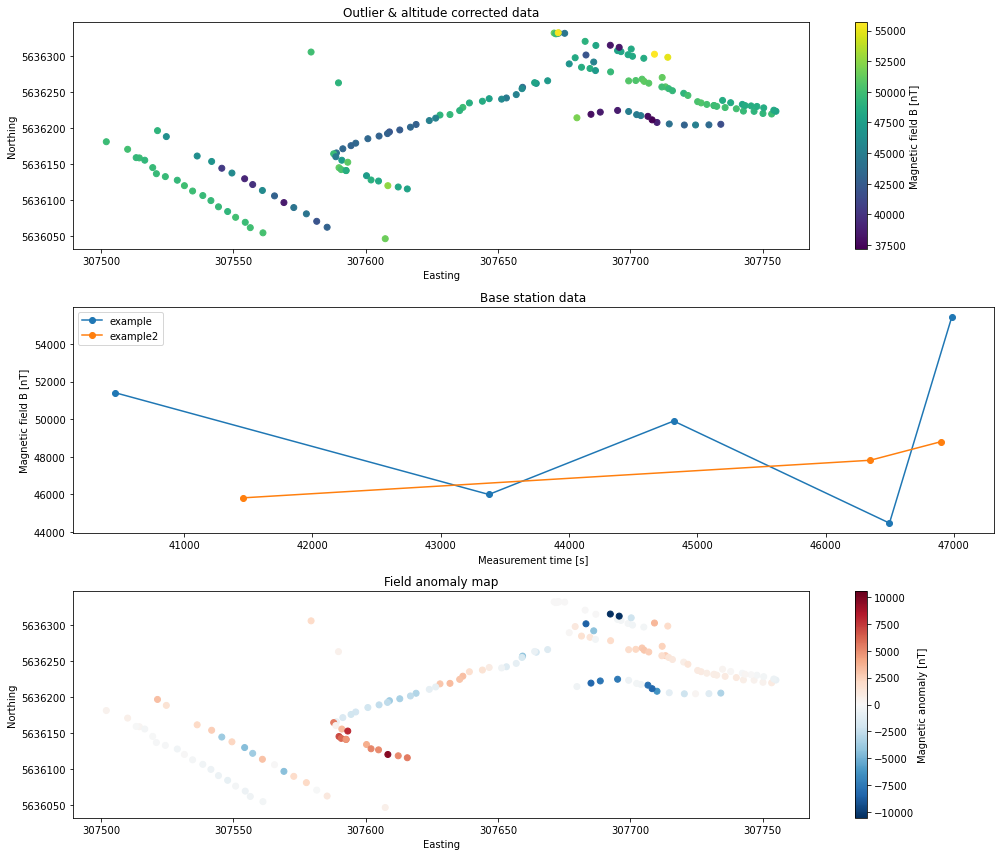

In [6]:
# Basic Anomaly map
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(14, 12))

vmin = -np.max(np.abs(data_combined['anomaly']))
vmax = np.max(np.abs(data_combined['anomaly']))

# Using the temporally corrected anomalies
im0 = ax0.scatter(data_combined['x'], data_combined['y'], c=data_combined['field_alt'])
namegroups = base_combined.groupby('name')
for name, group in namegroups:
    ax1.plot(group['times'], group['field'], '-o', label=name)
ax1.legend()
im2 = ax2.scatter(data_combined['x'], data_combined['y'], c=data_combined['anomaly'],
                  vmin=vmin, vmax=vmax, cmap="RdBu_r")

ax0.set(xlabel='Easting', ylabel='Northing', title='Outlier & altitude corrected data')
ax1.set(xlabel='Measurement time [s]', ylabel='Magnetic field B [nT]', title='Base station data')
ax2.set(xlabel='Easting', ylabel='Northing', title='Field anomaly map')
plt.colorbar(im0, ax=ax0, label='Magnetic field B [nT]');
#plt.colorbar(im1, ax=ax1, label='Magnetic field B [nT]');
plt.colorbar(im2, ax=ax2, label='Magnetic anomaly [nT]');

ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
ax2.set_yticklabels(['{:}'.format(int(x)) for x in ax2.get_yticks().tolist()]) # Fixes y-axis tick labels

plt.tight_layout()

## Interpolation over all datapoints

We also saved the interpolated values for each phone. One option would be to plot all interpolation results in the same plot. However, these values do not take into account the other phones' measurements. We can instead re-perform the interpolation, which takes some additional computing time but will yield results that integrate all data.

In [7]:
# Defining a grid of points for which we want to interpolate
# Defining resolution (number of gridpoints) in x- and y- direction
xRes = 100
yRes = xRes

xAxis = np.linspace(data_combined['x'].min(), data_combined['x'].max(), xRes)
yAxis = np.linspace(data_combined['y'].min(), data_combined['y'].max(), yRes)

In [8]:
# Performing interpolations over the whole domain
mgX, mgY = np.meshgrid(xAxis, yAxis)


nearest_neighbors = interpolate.griddata(list(zip(data_combined['x'], data_combined['y'])),
                                         data_combined['anomaly'],
                                     list(zip(mgX.flat, mgY.flat)), method='nearest').reshape(mgX.shape)

linear_spline = interpolate.griddata(list(zip(data_combined['x'], data_combined['y'])),
                                         data_combined['anomaly'],
                                     list(zip(mgX.flat, mgY.flat)), method='linear').reshape(mgX.shape)

Below we now plot the interpolated maps over the whole domain.

<ipython-input-9-d822383d0004>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


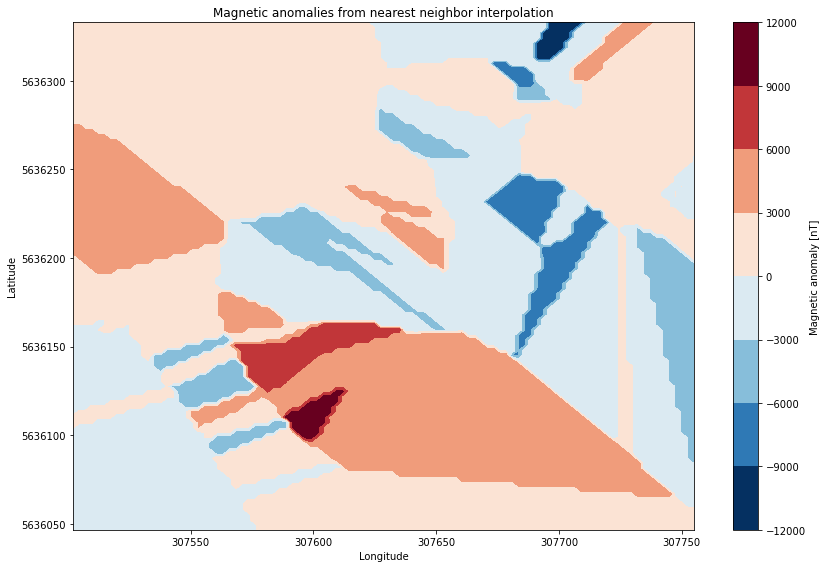

In [9]:
# plotting NN-results

fig, ax = plt.subplots(figsize=(12, 8))

im = ax.contourf(mgX, mgY, nearest_neighbors,
                 vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.set(xlabel='Longitude', ylabel='Latitude', title='Magnetic anomalies from nearest neighbor interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()

<ipython-input-10-421a0d549023>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


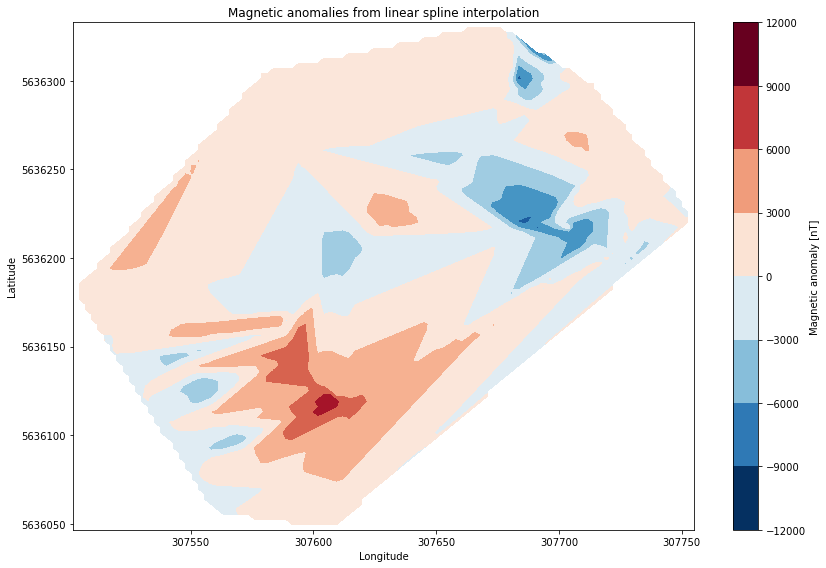

In [10]:
# Linear spline

fig, ax = plt.subplots(figsize=(12, 8))

ax.contourf(mgX, mgY, linear_spline,
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.set(xlabel='Longitude', ylabel='Latitude', title='Magnetic anomalies from linear spline interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()

## Selecting a subset of data

We can also take a look at only a subset of the data. Below you see two plots that lie within the specified ateral bounds, one showing the measured anomalies and the other one showing the interpolation results. Change the 'contourf' argument in order to see different interpolations.

#### Plotting the subset of data:

In [11]:
#ENTER THE X AND Y BOUNDS YOU WANT TO USE HERE
minX, maxX = 307550, 307650
minY, maxY = 5636050, 5636150

<ipython-input-12-f15398763b9d>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
<ipython-input-12-f15398763b9d>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:}'.format(int(x)) for x in ax1.get_yticks().tolist()]) # Fixes y-axis tick labels


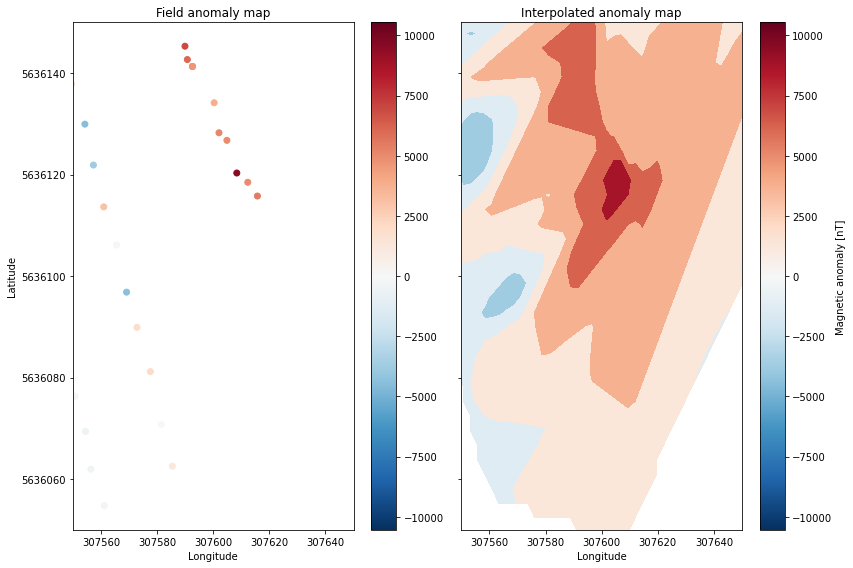

In [12]:
# Basic Anomaly map
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# Scatterplot for measured data
im0 = ax0.scatter(data_combined['x'], data_combined['y'], c=data_combined['anomaly'],
                  vmin=vmin, vmax=vmax, cmap="RdBu_r")

# Contourplot of interpolated data (change 'linear_spline' to method of choice)
im1 = ax1.contourf(mgX, mgY, linear_spline,
                   vmin=vmin, vmax=vmax, cmap="RdBu_r") 

# Some plot settings
ax0.set(xlabel='Longitude', ylabel='Latitude', title='Field anomaly map', xlim=(minX, maxX), ylim=(minY, maxY))
ax1.set(xlabel='Longitude', title='Interpolated anomaly map', xlim=(minX, maxX), ylim=(minY, maxY))
ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax0.get_yticks().tolist()]) # Fixes y-axis tick labels
ax1.set_yticklabels(['{:}'.format(int(x)) for x in ax1.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im0, ax=ax0)
plt.colorbar(im0, ax=ax1, label='Magnetic anomaly [nT]')
plt.tight_layout()

## Extracting a profile line

It is also possible to choose a specific profile line and plot only that. The profile can be defined by a start and an end point. We once again need to define a small tolerance within which values will be selected, since a true 1D line would likely not intersect any points at all.

In [13]:
# Enter Starting point coordinates here
profileStartX = 307500
profileStartY = 5636150

# Enter coordinates of profile endpoint here
profileEndX = 307800
profileEndY = 5636150

tol = 30

# Create a slim polygon that represents the profile line
selection = Polygon([[profileStartX-tol/2, profileStartY-tol/2], [profileEndX-tol/2, profileEndY-tol/2],
                    [profileEndX+tol/2, profileEndY+tol/2], [profileStartX+tol/2, profileStartY+tol/2]])

# Selecting datapoints that lie along the profile
selectMask = selection.contains_points(list(zip(data_combined['x'], data_combined['y'])))
profileX = data_combined['x'][selectMask]
profileY = data_combined['y'][selectMask]
profileAnomaly = np.array(data_combined['anomaly'][selectMask])

# Selecting points from the interpolation grid 
selectMaskInterp = selection.contains_points(list(zip(mgX.flat, mgY.flat)))
profileXInterp = mgX.flat[selectMaskInterp]
profileYInterp = mgY.flat[selectMaskInterp]
profileAnomalyInterp = np.array(linear_spline.flat[selectMaskInterp]) # Change linear_spline to desired interpolation

# Computing distances along the profile
distances = []
for _x, _y in zip(profileX, profileY):
    distances.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
distances = np.array(distances)
distances_sorted = distances[distances.argsort()]
anomalies_sorted = profileAnomaly[distances.argsort()]

# Computing distances for interpolated data
distancesInterp = []
for _x, _y in zip(profileXInterp, profileYInterp):
    distancesInterp.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
distancesInterp = np.array(distancesInterp)
distances_sortedInterp = distancesInterp[distancesInterp.argsort()]
anomalies_sortedInterp = profileAnomalyInterp[distancesInterp.argsort()]

<ipython-input-14-ad1c6cbc5225>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


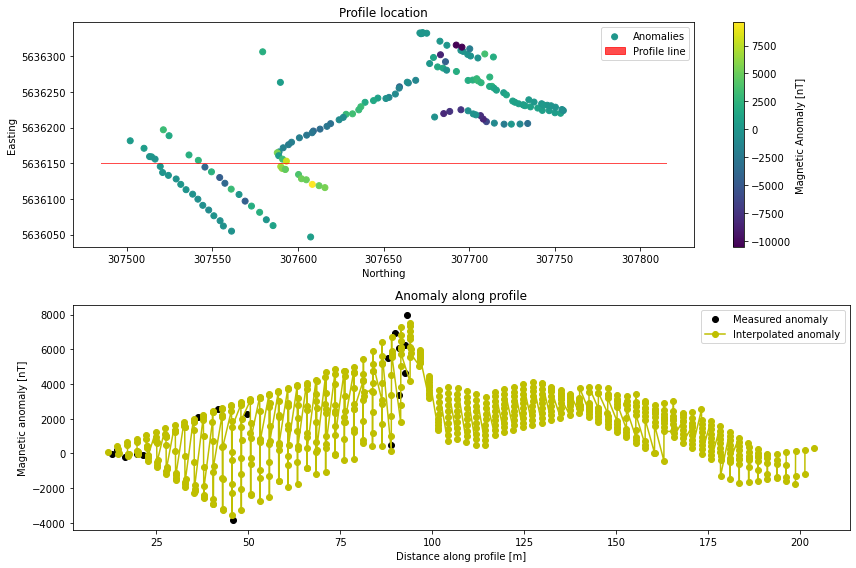

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8))

selection_plot = Polygon([[profileStartX-tol/2, profileStartY], [profileEndX-tol/2, profileEndY],
                         [profileEndX+tol/2, profileEndY], [profileStartX+tol/2, profileStartY]],
                         label='Profile line', color='r', alpha=.7)

ax0.add_patch(selection_plot)
im0 = ax0.scatter(data_combined['x'], data_combined['y'], c=data_combined['anomaly'], label='Anomalies')
im1 = ax1.plot(distances, profileAnomaly, 'ok', label='Measured anomaly')
im2 = ax1.plot(distances_sortedInterp, anomalies_sortedInterp, '-oy', label='Interpolated anomaly')

ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
ax0.legend(handles=[im0, selection_plot])
ax1.legend()

ax0.set(xlabel='Northing', ylabel='Easting', title='Profile location')
ax1.set(xlabel='Distance along profile [m]', ylabel='Magnetic anomaly [nT]', title='Anomaly along profile')
plt.colorbar(im0, ax=ax0, label='Magnetic Anomaly [nT]');

plt.tight_layout()

## Saving the data

Lastly, we save all data into one combined file.

#### Saving the profile data

In [19]:
# Give your profile a meaningful name and choose a folder (default is this notebooks' folder)
# The following code will save the measured profile data and teh interpolated profiledata into 2 different .csv files
profilefolder = Path('.')
profilename = 'profile'

profiledata_measured = pd.DataFrame({'Measured distance':distances_sorted,
                                     'Measured anomaly':anomalies_sorted})
profiledata_interpolated = pd.DataFrame({'Measured distance':distances_sortedInterp,
                                     'Measured anomaly':anomalies_sortedInterp})

profiledata_measured.to_csv(profilefolder / (profilename+'_measured.csv'))
profiledata_interpolated.to_csv(profilefolder / (profilename+'_interpolated.csv'))

In [20]:
folder = Path('.')
fileName = 'results_magnetic_ALL' + '.csv'
fileNameBase = 'results_magnetic_BASE' + '.csv'

data_combined.to_csv(folder / fileName)
base_combined.to_csv(folder / fileNameBase)
